# Machine Learning - Group Assignment 3

- Ankita Kokkera - 06032419
- Aria Wang - 06047688
- Tsamara Esperanti Erwin - 06042275
- Jean-Marc Yao - 06055972
- Amer Mulla - 06027165

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import time

### 1. Load the data set

In [2]:
loandata = pd.read_csv("loandata.csv")

### 2. Convert categorical predictors to numerical predictors

In [3]:
loandata_numeric = pd.get_dummies(loandata, drop_first=True)

### 3. Shuffle the data and split into training, validation, and test sets

In [4]:
# First split (data into 60% train and 40% temp)
train_data, temp_data = train_test_split(
    loandata_numeric,
    test_size = 0.4,
    random_state = 42,
    shuffle = True
)

# Second split (40% temp into 30% validation and 10% test)
val_data, test_data = train_test_split(
    temp_data,
    test_size = 0.25,
    random_state = 42,
    shuffle = True
)

### 4. Naive benchmark

In [5]:
y_train = train_data["Default_Yes"]
y_val = val_data["Default_Yes"]

majority_class = y_train.mode()[0]

y_val_pred_naive = [majority_class] * len(y_val)

naive_accuracy = accuracy_score(y_val, y_val_pred_naive)
print("Naive benchmark validation accuracy:", naive_accuracy)

Naive benchmark validation accuracy: 0.7458745874587459


### 5. Decision tree

In [6]:
X_train = train_data.drop(columns = ["Default_Yes"])
y_train = train_data["Default_Yes"]

X_val = val_data.drop(columns=["Default_Yes"])
y_val = val_data["Default_Yes"]

tree = DecisionTreeClassifier(max_depth = 3, random_state = 42)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_val_pred = tree.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Decision Tree training accuracy:", train_accuracy)
print("Decision Tree validation accuracy:", val_accuracy)


Decision Tree training accuracy: 0.8770627062706271
Decision Tree validation accuracy: 0.8448844884488449


In [7]:
depths = range(1, 21)
train_scores = []
val_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    val_scores.append(accuracy_score(y_val, clf.predict(X_val)))


val_scores   

[0.8399339933993399,
 0.8448844884488449,
 0.8448844884488449,
 0.834983498349835,
 0.8399339933993399,
 0.8316831683168316,
 0.8432343234323433,
 0.8316831683168316,
 0.8118811881188119,
 0.8151815181518152,
 0.8184818481848185,
 0.8184818481848185,
 0.8151815181518152,
 0.8168316831683168,
 0.8151815181518152,
 0.8184818481848185,
 0.8184818481848185,
 0.8151815181518152,
 0.8201320132013201,
 0.8201320132013201]

In [8]:
threshold = max(val_scores) 
candidate_depths = [d for d, v in zip(depths, val_scores) if v >= threshold]
chosen_depth = max(candidate_depths)
print("Chosen max_depth (near-best & simplest):", chosen_depth)

Chosen max_depth (near-best & simplest): 3


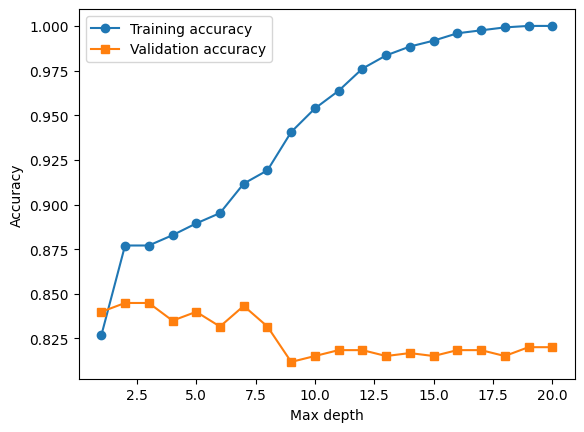

In [9]:
plt.plot(depths, train_scores, 'o-', label="Training accuracy")
plt.plot(depths, val_scores, 's-', label="Validation accuracy")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The maximum depth is chosen to balance model complexity and generalisation performance. Deeper trees overfit the training data, while shallow trees underfit. We tune the decision tree’s maximum depth using the validation set. While training accuracy increases monotonically with depth, validation accuracy peaks at shallow depths and then declines, indicating overfitting for deeper trees. We therefore choose a max depth of 3(or 2), which achieves the highest validation accuracy while keeping the model simple and interpretable.

The validation accuracy is the same for depth equal to 2 and 3, which is about 0.8448844884488449. Thus, if we want to create a simple decision tree we can choose depth at 2 which achieve a same accuracy as depth at 3. 

A tree with `max_depth = 3` was chosen as this is not too high (leading to model complexity and overfitting) and not too low (leading to an overly simplisitc model and underfitting). This depth thus provides a reasonable trade-off between bias and variance.

### 6. Random forest

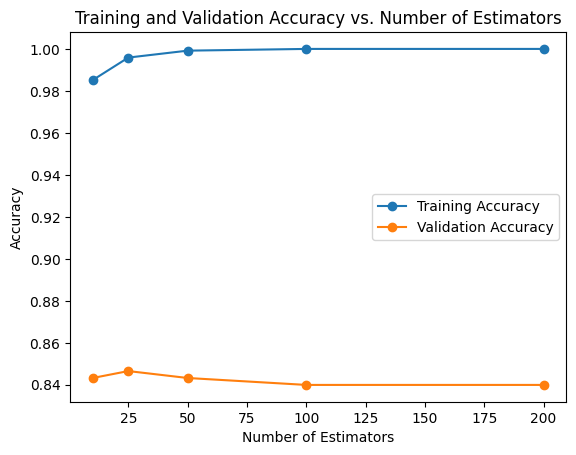

In [10]:
X_train = train_data.drop(columns = ["Default_Yes"])
y_train = train_data["Default_Yes"]

X_val = val_data.drop(columns = ["Default_Yes"])
y_val = val_data["Default_Yes"]

n_estimators_list = [10, 25, 50, 100, 200]

train_accuracies = []
val_accuracies = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators = n,
        random_state = 42
    )
    
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)
    
    train_accuracies.append(accuracy_score(y_train, train_pred))
    val_accuracies.append(accuracy_score(y_val, val_pred))

plt.figure()
plt.plot(n_estimators_list, train_accuracies, marker = 'o', label = "Training Accuracy")
plt.plot(n_estimators_list, val_accuracies, marker = 'o', label = "Validation Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs. Number of Estimators")
plt.legend()
plt.show()

As the number of estimators increase, training accuracy approaches 1, while validation accuracy improves only marginally and then stabilises. This indicates diminishing returns from adding more trees and suggests that larger forests do not substantially improve the performance of the model.

In [13]:
best_idx = val_accuracies.index(max(val_accuracies))
best_n = n_estimators_list[best_idx]
best_n

25

The optimal number of estimators is 25.

### 7. Random forest (training time)

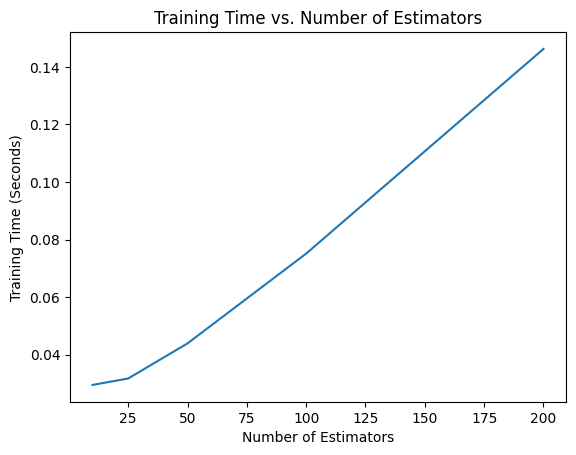

In [15]:
training_times = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=42
    )
    
    start_time = time.time()
    rf.fit(X_train, y_train)
    end_time = time.time()
    
    training_times.append(end_time - start_time)

plt.plot(n_estimators_list, training_times)
plt.xlabel("Number of Estimators")
plt.ylabel("Training Time (Seconds)")
plt.title("Training Time vs. Number of Estimators")
plt.show()

Training time increases approximately linearly as the number of estimators increases.

### 8. Comparison of decision tree and random forest

**Performance**: The random forest outperforms the decision tree on the validation set as it achieves higher accuracy. While the decision tree fits the training data well, its performance on unseen data is weaker, indicating a higher tendency to overfit. The ensemble nature of the random forest reduces variance and improves predictive accuracy.

**Interpretability**: The decision tree is highly interpretable as its structure allows predictions to be explained through simple decision rules. In contrast, the random forest is less interpretable because it aggregates predictions from many trees, making individual decisions difficult to interpret.

**Training Time**: The decision tree trains very quickly and requires less compute. The random forest requires more compute, with training time increasing approximately linearly with the number of estimators.

**Generalisability**: The random forest generalises better than the decision tree, as evidenced by its great validation accuracy and reduced sensitivity to noise. The decision tree is more proneto overfitting, whereas the random forest’s averaging mechanism improves robustness on unseen data.

Overall, the decision tree offers simplicity and interpretability, while the random forest provides improved performance and generalisation at the cost of increased training time and reduced interpretability.
